# Assignment-03
​
# BM23MTECH11006
​
# PITHANI TEJA VENKATA RAMANA KUMAR


### Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms


### Dataset

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:01<00:00, 100988651.95it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


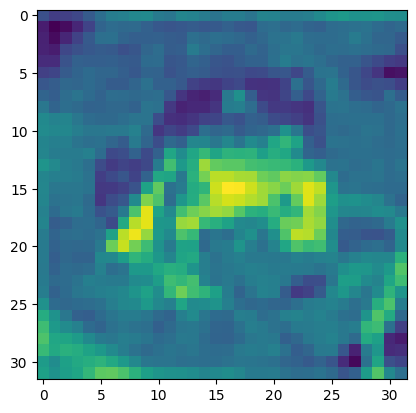

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(trainset[0][0][1])

#### 1. Self-Attention for Object Recognition with CNNs: Implement a sample CNN with one or more self-attention layer(s) for performing object recognition over CIFAR-10 dataset. You have to implement the self-attention layer yourself and use it in the forward function defined by you. All other layers (fully connected, nonlinearity, conv layer, etc.) can be bulit-in implementations. The network can be a simpler one (e.g., it may have 1x Conv, 4x [Conv followed by SA], 1x Conv, and 1x GAP). Please refer to the reading material provided here or any other similar one. [10 Marks]


In [ ]:
# Define the Self Attention Layer
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        proj_query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1)  # B x (N) x C
        proj_key = self.key_conv(x).view(batch_size, -1, width*height)  # B x C x (N)
        energy = torch.bmm(proj_query, proj_key)  # batch matrix multiplication
        attention = F.softmax(energy, dim=-1)  # normalize across keys
        proj_value = self.value_conv(x).view(batch_size, -1, width*height)  # B x C x N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x
        return out

# Define the CNN model with Self Attention
class SelfAttentionCNN(nn.Module):
    def __init__(self):
        super(SelfAttentionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.sa1 = SelfAttention(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.sa2 = SelfAttention(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.sa3 = SelfAttention(128)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 10, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.sa1(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = self.sa2(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = self.sa3(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)



In [ ]:
# Instantiate the model
net = SelfAttentionCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
net.to(device)

# Move the data to the GPU inside the training loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move input data to GPU
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


[1,   200] loss: 2.186
[1,   400] loss: 1.911
[1,   600] loss: 1.750
[2,   200] loss: 1.530
[2,   400] loss: 1.462
[2,   600] loss: 1.412
[3,   200] loss: 1.280
[3,   400] loss: 1.145
[3,   600] loss: 1.047
[4,   200] loss: 0.933
[4,   400] loss: 0.911
[4,   600] loss: 0.881
[5,   200] loss: 0.790
[5,   400] loss: 0.800
[5,   600] loss: 0.801
[6,   200] loss: 0.708
[6,   400] loss: 0.713
[6,   600] loss: 0.720
[7,   200] loss: 0.648
[7,   400] loss: 0.645
[7,   600] loss: 0.657
[8,   200] loss: 0.575
[8,   400] loss: 0.585
[8,   600] loss: 0.609
[9,   200] loss: 0.519
[9,   400] loss: 0.543
[9,   600] loss: 0.537
[10,   200] loss: 0.475
[10,   400] loss: 0.493
[10,   600] loss: 0.513
Finished Training


In [ ]:
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    device = next(model.parameters()).device  # Get the device where the model is located
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)  # Move input data to GPU
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy



In [ ]:
# Usage example:
# Assuming you have already defined your model and dataloader
test_accuracy = evaluate_accuracy(net, testloader)
print(f'Test Accuracy: {test_accuracy:.2%}')


Test Accuracy: 74.10%


#### 2. Object Recognition with Vision Transformer: Implement and train an Encoder only Transformer (ViT-like) for the above object recognition task. In other words, implement multi-headed self-attention for the image classification (i.e., appending a < class > token to the image patches that are accepted as input tokens). Compare the performance of the two implementations (try to keep the number of parameters to be comparable and use the same amount of training and testing data). [10 Marks]

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, embed_dim, num_heads, num_layers):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "image size must be divisible by patch size"
        num_patches = (image_size // patch_size) ** 2
        self.patch_embedding = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        self.transformer_encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embedding(x)  # B x C x H' x W'
        x = x.flatten(2).transpose(1, 2)  # B x (H' * W') x C
        x = torch.cat([self.class_embedding.expand(B, -1, -1), x], dim=1)  # B x (H' * W' + 1) x C
        x = x + self.positional_encoding  # B x (H' * W' + 1) x C
        for layer in self.transformer_encoder_layers:
            x = layer(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(embed_dim, embed_dim * 4)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(embed_dim * 4, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x, _ = self.self_attn(x, x, x)
        x = residual + self.dropout(x)
        residual = x
        x = self.norm2(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = residual + self.dropout(x)
        return x


In [ ]:
# Instantiate the Vision Transformer model
vit_model = VisionTransformer(image_size=32, patch_size=4, num_classes=10, embed_dim=64, num_heads=4, num_layers=4)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = vit_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}")
            running_loss = 0.0



Epoch [1/10], Step [100/782], Loss: 2.1624
Epoch [1/10], Step [200/782], Loss: 1.9749
Epoch [1/10], Step [300/782], Loss: 1.8804
Epoch [1/10], Step [400/782], Loss: 1.7990
Epoch [1/10], Step [500/782], Loss: 1.7369
Epoch [1/10], Step [600/782], Loss: 1.6977
Epoch [1/10], Step [700/782], Loss: 1.6706
Epoch [2/10], Step [100/782], Loss: 1.5867
Epoch [2/10], Step [200/782], Loss: 1.5729
Epoch [2/10], Step [300/782], Loss: 1.5468
Epoch [2/10], Step [400/782], Loss: 1.5129
Epoch [2/10], Step [500/782], Loss: 1.4996
Epoch [2/10], Step [600/782], Loss: 1.4965
Epoch [2/10], Step [700/782], Loss: 1.4751
Epoch [3/10], Step [100/782], Loss: 1.4568
Epoch [3/10], Step [200/782], Loss: 1.4123
Epoch [3/10], Step [300/782], Loss: 1.4427
Epoch [3/10], Step [400/782], Loss: 1.4129
Epoch [3/10], Step [500/782], Loss: 1.4189
Epoch [3/10], Step [600/782], Loss: 1.3823
Epoch [3/10], Step [700/782], Loss: 1.3453
Epoch [4/10], Step [100/782], Loss: 1.3437
Epoch [4/10], Step [200/782], Loss: 1.3500
Epoch [4/10

In [ ]:
# Evaluation
vit_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = vit_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy of the Vision Transformer model on the 10000 test images: {accuracy:.2%}')


Accuracy of the Vision Transformer model on the 10000 test images: 60.44%
